# Compare different ML models

- with first order derivatives
- across resolutions

In [1]:
import xarray as xr
import numpy as np 

import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
#from flax.core import freeze, unfreeze
from flax import linen as nn
from flax.training import train_state 
from flax.training import checkpoints

import optax
import xbatcher
import fsspec

#import hvplot.xarray

import matplotlib.pyplot as plt
from datatree import DataTree
from datatree import open_datatree

import xgcm

import sys

sys.path.append('../modules/')
import helper_func as hf
import ml_helper_func as ml_hf

In [2]:
import os 
M2LINES_BUCKET ='gs://leap-persistent/dhruvbalwada/m2lines_transfer'

In [3]:
# Open all the datasets
Lkey = ['50', '100', '200', '400']

ds = {}
for L in Lkey:
    
    ds_temp = xr.open_zarr(f'{M2LINES_BUCKET}/ML_data/ds_ML_'+L+'km_3D')
    
    ds[L] = ds_temp
ds_tree = DataTree.from_dict(ds)

# Open the mask files
ds_mask_tree = open_datatree(f'{M2LINES_BUCKET}/ML_data/ds_ML_masks', engine='zarr')

In [5]:
output_channels = ['Sfnx','Sfny']                                      
input_channels_single = ['U_x', 'U_y', 
                         'V_x', 'V_y',
                         'Sx', 'Sy'] 
input_channels_all = ['U_x', 'U_y', 
                      'V_x', 'V_y', 
                      'Sx', 'Sy', 'Lfilt']

In [6]:
# Normalize by T_z for some variables
# Center all the data
facs = {}

ds_tree_centered = {}
for L in Lkey:
    
    # Select dataset
    ds = ds_tree[L].ds
    grid = xgcm.Grid(ds, periodic='X')
    
    # Center the variables
    ds_centered = hf.center_data(ds)
    ds_centered['T_z'] = (ds_centered['T_z'].where(ds_centered['T_z']>=5e-5, 5e-5)) #.isel(time=0, XC=0).plot(vmin=-6e-3)

    # Add variables that are actually used in the model.
    ds_centered['Sx'] = -ds_centered['T_x']/ds_centered['T_z']
    ds_centered['Sy'] = -ds_centered['T_y']/ds_centered['T_z']

    ds_centered['Sfnx'] =  - ds_centered['uT']/ds_centered['T_z']
    ds_centered['Sfny'] =  - ds_centered['vT']/ds_centered['T_z']

    ds_centered['Lfilt'] = (float(L) + 0*ds_centered.T)
#     # Compute the VGM 
#     dx = ds_centered.dxC[0,0].values
#     fac = 13/6 * dx *dx 
    
#     # Save the factors
#     facs[L] = fac
        
#     # VGM Model 
#     ds_centered['uT_vgm'] = fac*(ds_centered.U_x*ds_centered.T_x + ds_centered.U_y*ds_centered.T_y)
#     ds_centered['vT_vgm'] = fac*(ds_centered.V_x*ds_centered.T_x + ds_centered.V_y*ds_centered.T_y)  
    
#     # GM model
    
#     #ds_centered['uT_vgm'] = uT_vgm
#     ds_centered['vT_gm'] = -1e4*ds_centered.T_y

    # Only consider variables that will be used in ML
    ds_ML_vars = xr.merge([ds_centered[output_channels], ds_centered[input_channels_all]])
    
    ds_tree_centered[L] = ds_ML_vars
    
ds_tree_centered = DataTree.from_dict(ds_tree_centered)

In [7]:
# Open standardization constants file (divide by std) 

ds_std_tree = {}
for L in Lkey:
    #print(L)
    ds = ds_tree_centered[L].to_dataset()

    ds_var = list(ds.keys())
    
    ds_mask = ds_mask_tree[L].to_dataset().maskC
    
    try: 
        ds_std = xr.open_zarr('./STD_'+L+'_km.nc')
        print('Found '+L+'km standard deviations on local')
    except:
        print('Not found')
        ds_std = hf.compute_std(ds, ds_mask, slice(0,100))
        ds_std.compute();
        ds_std.to_zarr('./STD_'+L+'_km.nc')
    
    #ds_normalized = hf.normalize_ds(ds, ds_std)

    ds_std_tree[L] = ds_std
    
ds_std_tree['all'] = xr.open_zarr('./STD_all.nc')
ds_std_tree = DataTree.from_dict(ds_std_tree)

Found 50km standard deviations on local
Found 100km standard deviations on local
Found 200km standard deviations on local
Found 400km standard deviations on local


In [96]:
# Define the state of the model
#import ml_helper_func as ml_hf
#import optax
#from flax.training import train_state  # Useful dataclass to keep train state
#from flax.training import checkpoints

model, params = ml_hf.initialize_model([24, 24, 2], len(input_channels_single) )

learning_rate = .01
tx = optax.sgd(learning_rate=learning_rate)
state = train_state.TrainState.create(
            apply_fn=model.apply, params=params, tx=tx)

#model_all, params_all = ml_hf.initialize_model([24, 24, 2], len(input_channels_all) )
model_all, params_all = ml_hf.initialize_model([24, 24, 2], len(input_channels_single) )

learning_rate = .01
tx_all = optax.sgd(learning_rate=learning_rate)
state_all = train_state.TrainState.create(
            apply_fn=model_all.apply, params=params_all, tx=tx_all)

In [97]:
# Load the trained models in.

restored_states = {}

ds_pred_tree = {}
for L in Lkey: 
    
    print(L)
    # load model
    CKPT_DIR = './ckpts_'+ L 
    restored_states[L] = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    
restored_states['all'] = checkpoints.restore_checkpoint(ckpt_dir='./ckpts_single_all_res_small_no_L/', target=state_all)

50
100
200
400


In [86]:
# Do inference for some scale using model at same scale

ds_pred_tree = {}
for L in Lkey: 
    
    print(L)
    ds_mask = ds_mask_tree[L].ds.maskC
    ds = ds_tree_centered[L].to_dataset().where(ds_mask>0.99999)
    ds_std = ds_std_tree[L].to_dataset()
    
    # put data properly 
    ds_input = ds[input_channels_single]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
    ds_output = ds[output_channels]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
    ds_all = xr.merge( (ds_input, ds_output))
    ds_test = ds_all.isel(time=slice(-10, -1)) 
    
    ds_test_normalized = ds_test/ds_std
    
    restored_state = restored_states[L]
    
    y_pred = restored_state.apply_fn(restored_state.params, 
                                     ds_test_normalized[input_channels_single].to_array().transpose(...,'variable'))
    
    dims = ds_test[output_channels].to_array().transpose(...,'variable').dims
    coords = ds_test[output_channels].to_array().transpose(...,'variable').coords

    ds_pred = xr.DataArray( y_pred, dims=dims, coords=coords).to_dataset(dim='variable')
    
    # Scale back
    ds_pred_unnormalized = xr.Dataset()
      
    ds_pred_unnormalized['Sfnx_pred'] = ds_pred['Sfnx'] * ds_std['Sfnx']
    ds_pred_unnormalized['Sfny_pred'] = ds_pred['Sfny'] * ds_std['Sfny']
    
    ds_pred_unnormalized['Sfnx_true'] = ds_test['Sfnx'] 
    ds_pred_unnormalized['Sfny_true'] = ds_test['Sfny']  
    
    ds_pred_tree[L] = ds_pred_unnormalized
    
ds_pred_tree = DataTree.from_dict(ds_pred_tree)

50
100
200
400


In [99]:
# Do inference for all datasets using all models.
Lkey_copy = Lkey.copy()
Lkey_copy.append('all')

ds_pred_tree_mix = {}
for L in Lkey: # Which data
    for L2 in Lkey_copy: # which model
    
        print(L, L2)
        ds_mask = ds_mask_tree[L].ds.maskC
        ds = ds_tree_centered[L].to_dataset().where(ds_mask>0.99999)
        

        # put data properly 
        if L2 != 'all':
            ds_std = ds_std_tree[L2].to_dataset()
            
            ds_input = ds[input_channels_single]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
            ds_output = ds[output_channels]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
            ds_all = xr.merge( (ds_input, ds_output))
            ds_test = ds_all.isel(time=slice(-10, -1)) 

            ds_test_normalized = ds_test/ds_std

            restored_state = restored_states[L2]

            y_pred = restored_state.apply_fn(restored_state.params, 
                                             ds_test_normalized[input_channels_single].to_array().transpose(...,'variable'))
        else:
            ds_std = ds_std_tree[L2].to_dataset()
            
            #ds_input = ds[input_channels_all]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
            ds_input = ds[input_channels_single]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
            
            ds_output = ds[output_channels]#.sel(YC=slice(200e3, 1800e3))#.sel(Z=slice(0, -2000))
            ds_all = xr.merge( (ds_input, ds_output))
            ds_test = ds_all.isel(time=slice(-10, -1)) 

            ds_test_normalized = ds_test/ds_std

            restored_state = restored_states[L2]

            y_pred = restored_state.apply_fn(restored_state.params, 
                                             #ds_test_normalized[input_channels_all].to_array().transpose(...,'variable'))
                                             ds_test_normalized[input_channels_single].to_array().transpose(...,'variable'))
            
        
        dims = ds_test[output_channels].to_array().transpose(...,'variable').dims
        coords = ds_test[output_channels].to_array().transpose(...,'variable').coords

        ds_pred = xr.DataArray(y_pred, dims=dims, coords=coords).to_dataset(dim='variable')

        # Scale back
        ds_pred_unnormalized = xr.Dataset()

        ds_pred_unnormalized['Sfnx_pred'] = ds_pred['Sfnx'] * ds_std['Sfnx']
        ds_pred_unnormalized['Sfny_pred'] = ds_pred['Sfny'] * ds_std['Sfny']

        ds_pred_unnormalized['Sfnx_true'] = ds_test['Sfnx'] 
        ds_pred_unnormalized['Sfny_true'] = ds_test['Sfny']  

        ds_pred_tree_mix[L+'-'+L2] = ds_pred_unnormalized
    
ds_pred_tree_mix = DataTree.from_dict(ds_pred_tree_mix)

50 50
50 100
50 200
50 400
50 all
100 50
100 100
100 200
100 400
100 all
200 50
200 100
200 200
200 400
200 all
400 50
400 100
400 200
400 400
400 all


In [88]:
ds_pred_tree_mix.load();

In [89]:
ds_pred = ds_pred_tree_mix['200-all'].to_dataset()

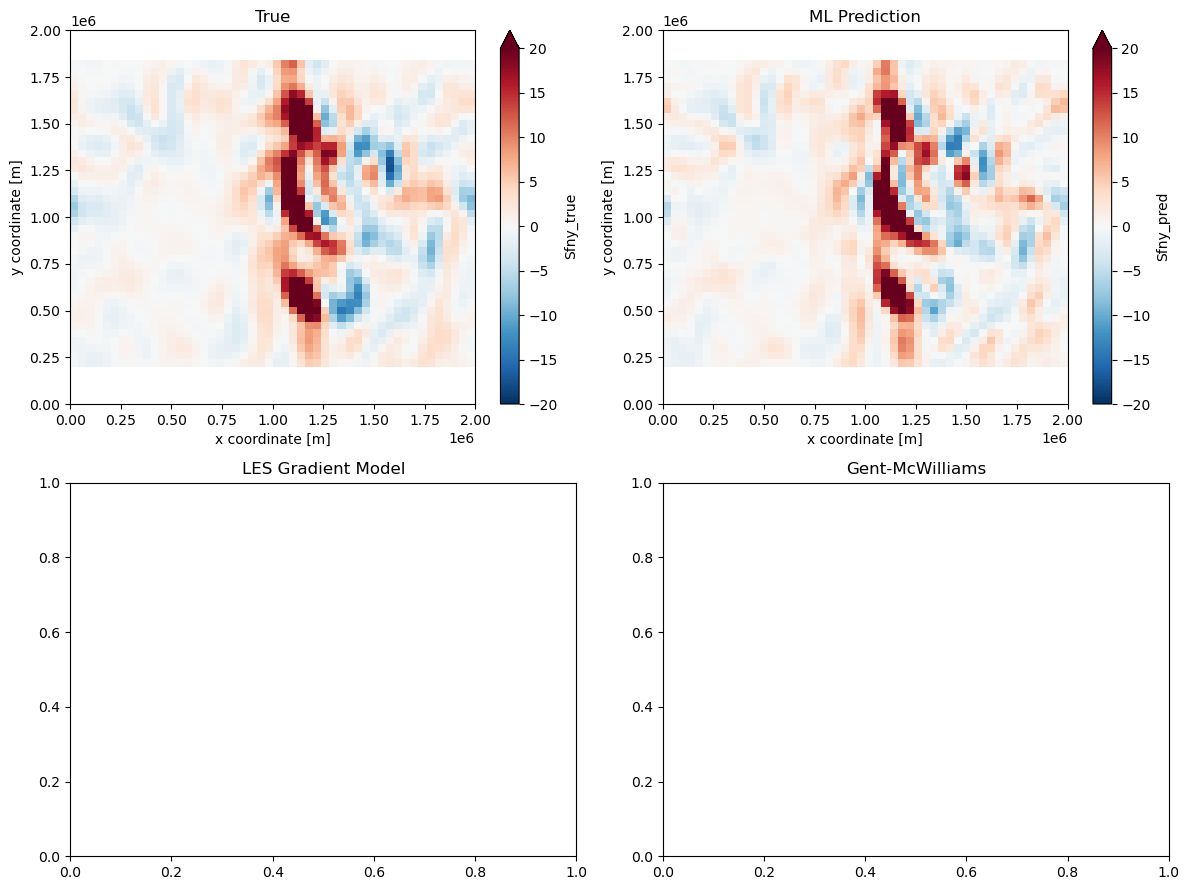

In [90]:
plt.figure(figsize=(12, 9))
zlev=15
vlevs = 20
plt.subplot(221)
ds_pred.Sfny_true.isel(time=0, Z=zlev).plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')

plt.subplot(222)
ds_pred.Sfny_pred.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('ML Prediction')

plt.subplot(223)
#ds_pred.vT_vgm.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('LES Gradient Model')

plt.subplot(224)
#ds_pred.vT_gm.isel(time=0, Z=zlev).plot(vmin=-vlevs)
plt.title('Gent-McWilliams')

plt.tight_layout()
#plt.savefig('Comparison.png')

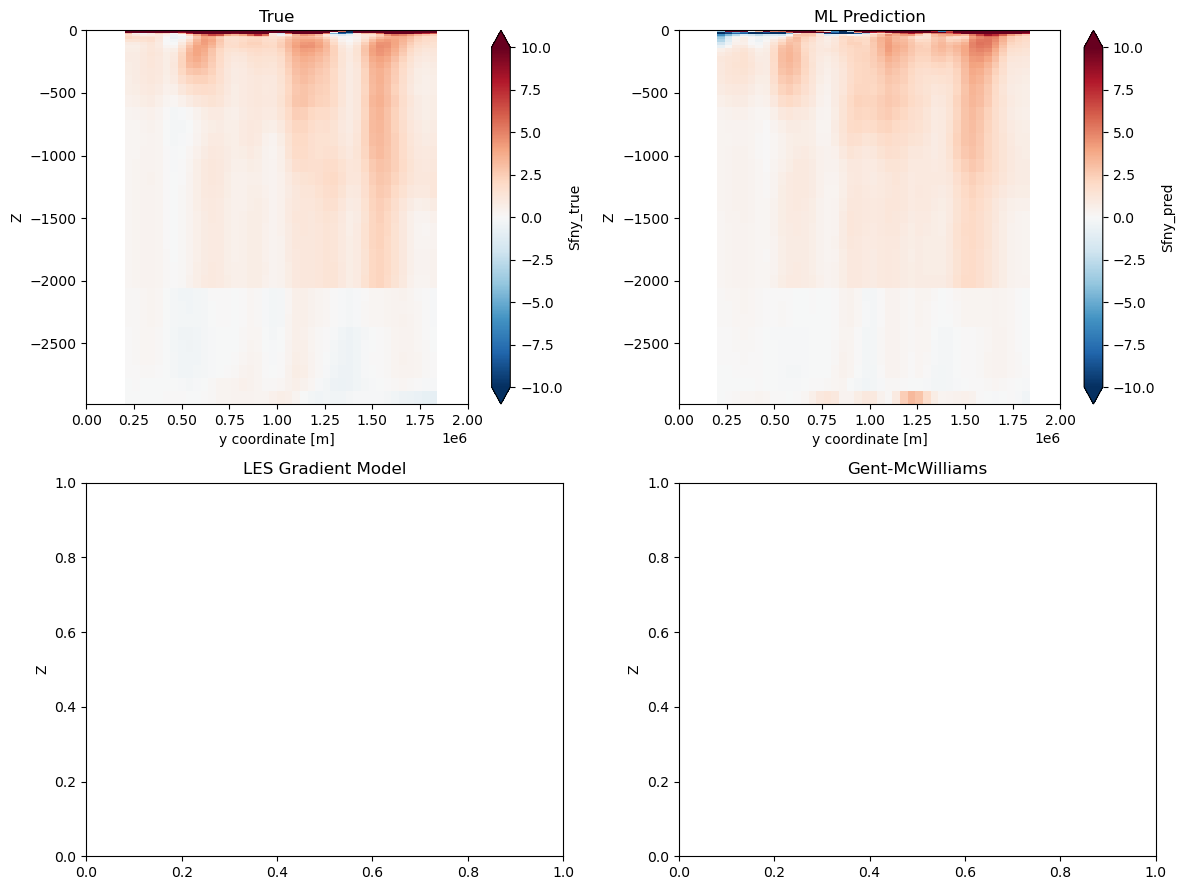

In [56]:
plt.figure(figsize=(12, 9))
zlev=5
vlevs = 10
plt.subplot(221)
ds_pred.Sfny_true.isel(time=0).mean('XC').plot(vmin=-vlevs, vmax=vlevs, cmap='RdBu_r')
plt.title('True')
plt.ylabel('Z')

plt.subplot(222)
ds_pred.Sfny_pred.isel(time=0).mean('XC').plot(vmin=-vlevs)
plt.title('ML Prediction')
plt.ylabel('Z')

plt.subplot(223)
#ds_pred.vT_vgm.isel(time=0).mean('XC').plot(vmin=-vlevs)
plt.title('LES Gradient Model')
plt.ylabel('Z')

plt.subplot(224)
#ds_pred.vT_gm.isel(time=0).mean('XC').plot(vmin=-vlevs*3)
plt.title('Gent-McWilliams')
plt.ylabel('Z')

plt.tight_layout()
#plt.savefig('Comparison_mean.png')

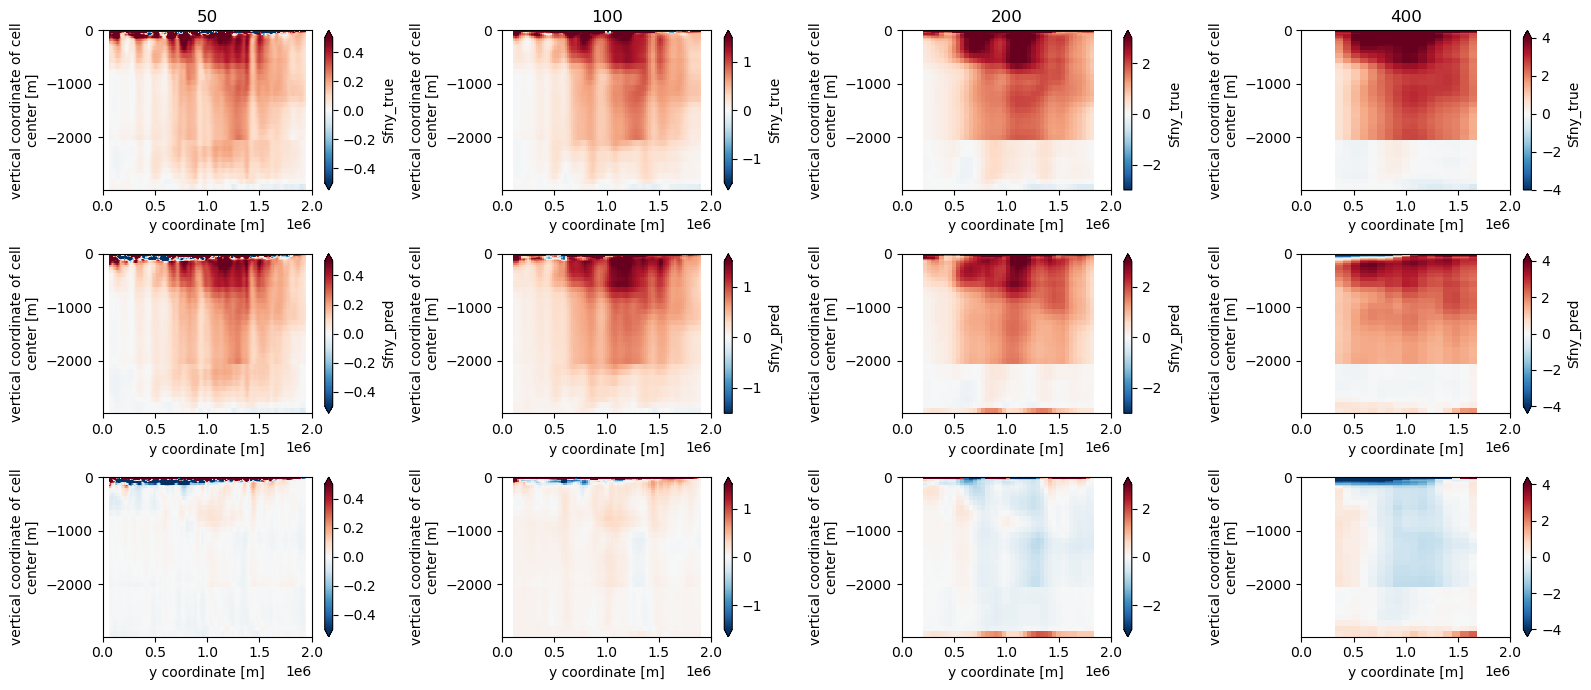

In [57]:
plt.figure(figsize=(16, 7))

#vlevs = [0.01, 0.005, 0.0025, 0.0012] 

vlevs = [.5, 1.5, 3., 4.]

for i,L in enumerate(Lkey): 
    plt.subplot(3,4,1+i)
    ds_pred_tree[L]['Sfny_true'].mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    plt.title(L)
    
    plt.subplot(3,4,1+i + 4)
    ds_pred_tree[L]['Sfny_pred'].mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    
    plt.subplot(3,4,1+i + 8)
    (ds_pred_tree[L]['Sfny_pred']-ds_pred_tree[L]['Sfny_true']).mean(['time', 'XC']).plot(vmin=-vlevs[i], vmax=vlevs[i], cmap='RdBu_r')
    
    
plt.tight_layout()

In [58]:
def R2_Z(ds, var='Sfny'):
    
    da_pred = ds[var+'_pred'].sel(YC=slice(400e3, 1600e3))
    da_truth = ds[var+'_true'].sel(YC=slice(400e3, 1600e3))
    
    RSS = ((da_pred  - da_truth)**2).mean(['time','YC','XC'])
    TSS = (da_truth**2).mean(['time','YC','XC'])
    R2_Z = 1 - RSS/TSS
    
    return R2_Z

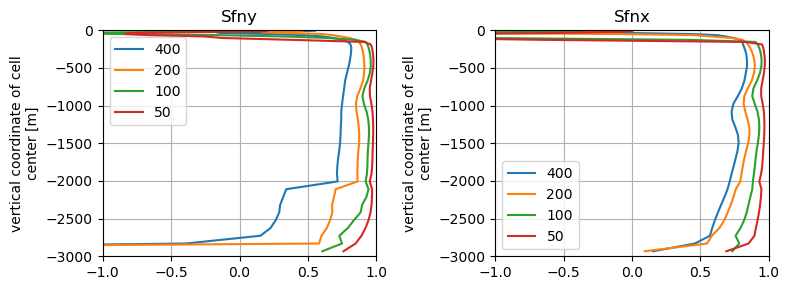

In [59]:
plt.figure(figsize = (8 , 3) )

plt.subplot(121)
R2_Z(ds_pred_tree['400']).plot(y='Z', label='400')
R2_Z(ds_pred_tree['200']).plot(y='Z', label='200')
R2_Z(ds_pred_tree['100']).plot(y='Z', label='100')
R2_Z(ds_pred_tree['50']).plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfny')


plt.subplot(122)
R2_Z(ds_pred_tree['400'], 'Sfnx').plot(y='Z', label='400')
R2_Z(ds_pred_tree['200'], 'Sfnx').plot(y='Z', label='200')
R2_Z(ds_pred_tree['100'], 'Sfnx').plot(y='Z', label='100')
R2_Z(ds_pred_tree['50'], 'Sfnx').plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfnx')

plt.tight_layout()

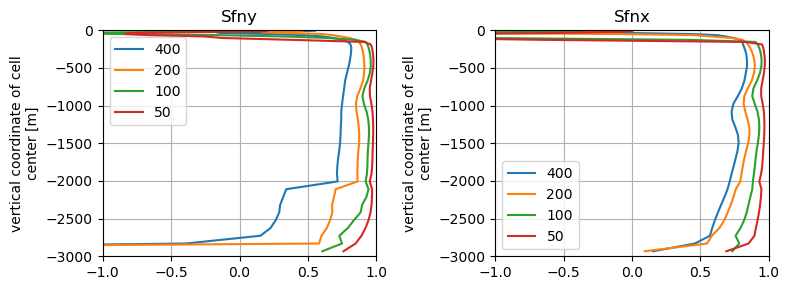

In [60]:

plt.figure(figsize = (8 , 3) )

plt.subplot(121)
R2_Z(ds_pred_tree_mix['400-400']).plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-200']).plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-100']).plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-50']).plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfny')


plt.subplot(122)
R2_Z(ds_pred_tree_mix['400-400'], 'Sfnx').plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-200'], 'Sfnx').plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-100'], 'Sfnx').plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-50'], 'Sfnx').plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfnx')

plt.tight_layout()

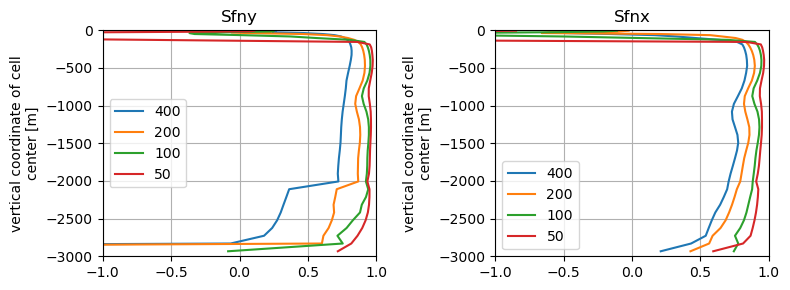

In [61]:

plt.figure(figsize = (8 , 3) )

plt.subplot(121)
R2_Z(ds_pred_tree_mix['400-all']).plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-all']).plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-all']).plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-all']).plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfny')


plt.subplot(122)
R2_Z(ds_pred_tree_mix['400-all'], 'Sfnx').plot(y='Z', label='400')
R2_Z(ds_pred_tree_mix['200-all'], 'Sfnx').plot(y='Z', label='200')
R2_Z(ds_pred_tree_mix['100-all'], 'Sfnx').plot(y='Z', label='100')
R2_Z(ds_pred_tree_mix['50-all'], 'Sfnx').plot(y='Z', label='50')

plt.xlim([-1, 1])
plt.ylim([-3000, 0])
plt.grid()
plt.legend()
plt.title('Sfnx')

plt.tight_layout()

In [62]:
def R2_score(true, pred, dims):
    RSS = ((true  - pred)**2).mean(dims)
    TSS = ((true)**2).mean(dims)
    R2 = 1 - RSS/TSS
    return R2 

In [50]:
ds_pred_tree_mix

DataTree('None', parent=None)
├── DataTree('50-50')
│       Dimensions:    (YC: 200, XC: 200, Z: 40, time: 9)
│       Coordinates:
│           Depth      (YC, XC) float32 1.492e+03 1.492e+03 ... 2.985e+03 2.985e+03
│           PHrefC     (Z) float32 49.05 147.1 245.2 ... 2.676e+04 2.777e+04 2.878e+04
│         * XC         (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * YC         (YC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * Z          (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│           drF        (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
│           hFacC      (Z, YC, XC) float32 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           iter       (time) int64 19250784 19254240 19257696 ... 19274976 19278432
│           maskC      (Z, YC, XC) float64 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           rA         (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
│         * time       (time) timedelta64[ns] 66843 days 66855 days ... 66939 days
│       Data variables:
│           Sfnx_pred  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfny_pred  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfnx_true  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfny_true  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
├── DataTree('50-100')
│       Dimensions:    (YC: 200, XC: 200, Z: 40, time: 9)
│       Coordinates:
│           Depth      (YC, XC) float32 1.492e+03 1.492e+03 ... 2.985e+03 2.985e+03
│           PHrefC     (Z) float32 49.05 147.1 245.2 ... 2.676e+04 2.777e+04 2.878e+04
│         * XC         (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * YC         (YC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * Z          (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│           drF        (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
│           hFacC      (Z, YC, XC) float32 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           iter       (time) int64 19250784 19254240 19257696 ... 19274976 19278432
│           maskC      (Z, YC, XC) float64 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           rA         (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
│         * time       (time) timedelta64[ns] 66843 days 66855 days ... 66939 days
│       Data variables:
│           Sfnx_pred  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfny_pred  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfnx_true  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
│           Sfny_true  (time, Z, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan
├── DataTree('50-200')
│       Dimensions:    (YC: 200, XC: 200, Z: 40, time: 9)
│       Coordinates:
│           Depth      (YC, XC) float32 1.492e+03 1.492e+03 ... 2.985e+03 2.985e+03
│           PHrefC     (Z) float32 49.05 147.1 245.2 ... 2.676e+04 2.777e+04 2.878e+04
│         * XC         (XC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * YC         (YC) float32 5e+03 1.5e+04 2.5e+04 ... 1.985e+06 1.995e+06
│         * Z          (Z) float32 -5.0 -15.0 -25.0 ... -2.728e+03 -2.83e+03 -2.934e+03
│           drF        (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0
│           hFacC      (Z, YC, XC) float32 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           iter       (time) int64 19250784 19254240 19257696 ... 19274976 19278432
│           maskC      (Z, YC, XC) float64 0.5 0.5 0.5 0.5 0.5 ... 1.0 1.0 1.0 1.0 1.0
│           rA         (YC, XC) float32 1e+08 1e+08 1e+08 1e+08 ... 1e+08 1e+08 1e+08
│         * time       (time) timedelta64[ns] 66843 days 66855 days ... 66939 days
│       Data variables:
│           Sfnx_pred  (time, Z, YC, XC) float32 nan nan nan nan

In [78]:
R2_all_y = np.zeros((4,))
Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree[L]
        
 #   da_pred  = ds['uT_pred'].sel(YC=slice(400e3, 1600e3))
 #   da_truth = ds['uT_true'].sel(YC=slice(400e3, 1600e3))
    
    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_y[i] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
    Lscale[i] = int(L)

R2_all_x = np.zeros((4,))
Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree[L]
        
 #   da_pred  = ds['uT_pred'].sel(YC=slice(400e3, 1600e3))
 #   da_truth = ds['uT_true'].sel(YC=slice(400e3, 1600e3))
    
    true = ds['Sfnx_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfnx_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_x[i] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
    Lscale[i] = int(L)

In [100]:
R2_all_y_all = np.zeros((4,))
Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree_mix[L+'-all']
  
    true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_y_all[i] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
    Lscale[i] = int(L)
    
R2_all_x_all = np.zeros((4,))
Lscale = np.zeros((4,))
for i, L in enumerate(Lkey):
    ds = ds_pred_tree_mix[L+'-all']
  
    true = ds['Sfnx_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
    pred = ds['Sfnx_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

    R2_all_x_all[i] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
    Lscale[i] = int(L)


In [92]:
print(R2_all_x)
print(R2_all_x_all)

print(R2_all_y)
print(R2_all_y_all)

[0.96128654 0.92805856 0.87145758 0.81097198]
[0.92583673 0.9133697  0.86606611 0.79113322]
[0.97119325 0.94484353 0.89428508 0.78240389]
[0.93442427 0.92690908 0.8874177  0.76089015]


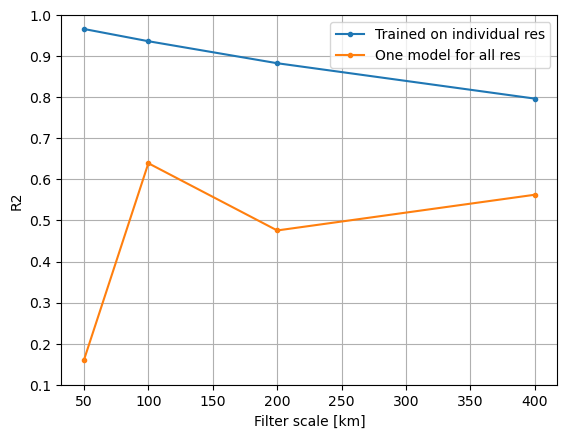

In [102]:
#plt.plot(Lscale, R2_all_x,'.-', label='ML first order gradients, X-dir')
#plt.plot(Lscale, R2_all_y,'.-', label='ML first order gradients, Y-dir')
plt.plot(Lscale, 0.5*(R2_all_y+R2_all_x),'.-', label='Trained on individual res')


#plt.plot(Lscale, R2_all_x_all,'o-', label='ML first order gradients, X-dir')
#plt.plot(Lscale, R2_all_y_all,'o-', label='ML first order gradients, Y-dir')
plt.plot(Lscale, 0.5*(R2_all_y_all+R2_all_x_all),'.-', label='One model for all res')

#plt.plot(Lscale, R2_vgm,'o--', label='VGM')
plt.xlabel('Filter scale [km]')
plt.ylabel('R2')
plt.ylim([0.1, 1.])
plt.legend()
#plt.title('First order models')
plt.grid()

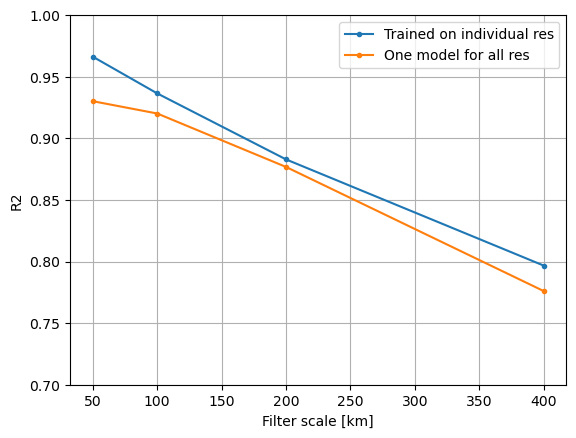

In [93]:
#plt.plot(Lscale, R2_all_x,'.-', label='ML first order gradients, X-dir')
#plt.plot(Lscale, R2_all_y,'.-', label='ML first order gradients, Y-dir')
plt.plot(Lscale, 0.5*(R2_all_y+R2_all_x),'.-', label='Trained on individual res')


#plt.plot(Lscale, R2_all_x_all,'o-', label='ML first order gradients, X-dir')
#plt.plot(Lscale, R2_all_y_all,'o-', label='ML first order gradients, Y-dir')
plt.plot(Lscale, 0.5*(R2_all_y_all+R2_all_x_all),'.-', label='One model for all res')

#plt.plot(Lscale, R2_vgm,'o--', label='VGM')
plt.xlabel('Filter scale [km]')
plt.ylabel('R2')
plt.ylim([0.7, 1.])
plt.legend()
#plt.title('First order models')
plt.grid()

In [29]:
R2_all_y_mix = np.zeros((4,5))
Lscale1 = np.zeros((4,))
Lscale2 = np.zeros((4,))

for i, L in enumerate(Lkey):
    for j, L2 in enumerate(Lkey_copy):
        ds = ds_pred_tree_mix[L+'-'+L2]
        
        true = ds['Sfny_true'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))
        pred = ds['Sfny_pred'].isel(time=slice(-30, -1)).sel(YC=slice(400e3, 1600e3), Z=slice(-200, -2000))

        R2_all_y_mix[i, j] =  R2_score(true, pred, ['XC', 'YC', 'time','Z']).values
        #Lscale2[j] = int(L2)
        
    Lscale1[i] = int(L)

In [37]:
R2_all_y_mix

array([[ 9.71193252e-01, -7.05428410e+00, -8.68656921e+01,
        -2.53807190e+02,  9.65004699e-01],
       [ 3.97013485e-01,  9.44843527e-01, -5.40338326e+00,
        -3.13145180e+01,  9.41199229e-01],
       [ 8.29082727e-02,  3.36015642e-01,  8.94285142e-01,
        -2.05136514e+00,  8.97263973e-01],
       [ 8.47685337e-03,  4.37977910e-02,  1.90070212e-01,
         7.82403901e-01,  7.87694860e-01]])

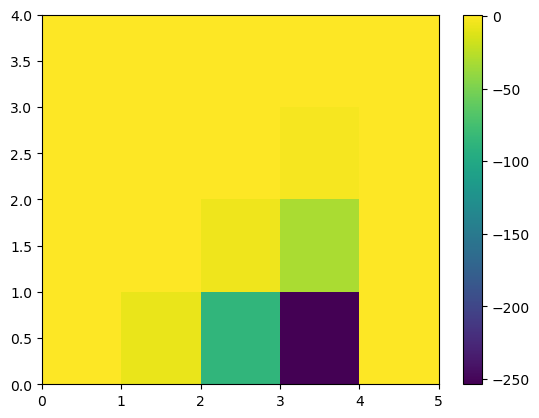

In [31]:
plt.pcolormesh(R2_all_y_mix)
plt.colorbar()

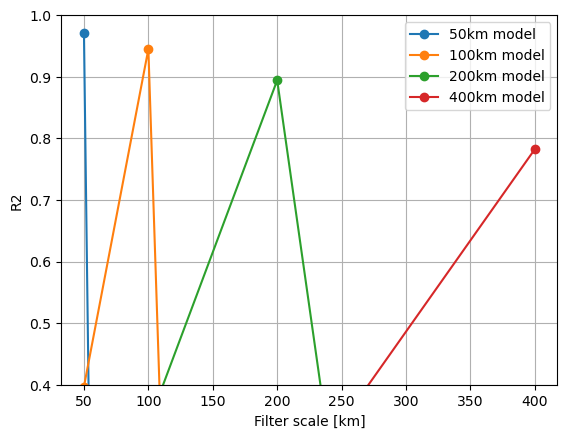

In [36]:
plt.plot(Lscale1, R2_all_y_mix[0,0:-1],'o-', label='50km model')
plt.plot(Lscale1, R2_all_y_mix[1,0:-1],'o-', label='100km model')
plt.plot(Lscale1, R2_all_y_mix[2,0:-1],'o-', label='200km model')
plt.plot(Lscale1, R2_all_y_mix[3,0:-1],'o-', label='400km model')

#plt.plot(Lscale1, R2_all_y, '.--', label='To each their own',  color='k', linewidth=2)

#plt.plot(Lscale, R2_vgm,'o--', label='VGM')
plt.xlabel('Filter scale [km]')
plt.ylabel('R2')
plt.ylim([0.4, 1.])
plt.legend()
#plt.title('First order models')
plt.grid()